## Recognizing Locations from extracted text

Different methods to get the location the RTS broadcasts are about

In [ ]:
# ! pip install folium

In [1]:
from emv.db.dao import DataAccessObject
from sqlalchemy.sql import text
import pandas as pd
import numpy as np
import json
import folium
from collections import Counter
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

from emv.client.get_content import get_features
from emv.utils import dataframe_from_hdf5
from emv.features.wikidata import get_wikidata_id, get_property, get_wikidata_label
from emv.features.wikidata import process_batch

# Load data with query

In [ ]:
query = text("""SELECT * FROM feature WHERE feature_type = 'transcript+ner';""")
df = pd.DataFrame(DataAccessObject().fetch_all(query))

In [ ]:
loc_entities = []

for i, row in df.iterrows():
    try:
        for ent in row['data']['entities']:
            if ent[1] == 'LOC':
                loc_entities.append(ent[0].lower())
                # print(ent['text'])
        # print(row['data']['entities'])
    except KeyError:
        pass

In [ ]:
series = pd.Series(loc_entities).value_counts()

In [ ]:
all_locs = []
for s in series.items():
    all_locs.append(s)
print(all_locs)

## Match streets

In [ ]:
streets = []
for i, row in df.iterrows():
    try:
        for t in row['data']['transcript']:
            streets.append(t['t'])
        # row['data']['transcript'][0]['t']
    except KeyError:
        pass
    except TypeError:
        pass

In [ ]:
for i, row in df.iterrows():
    try:
        for t in row['data']['transcript']:
            if 'rue de' in t['t'].lower():
                print(t['t'])
        # row['data']['transcript'][0]['t']
    except KeyError:
        pass
    except TypeError:
        pass

In [ ]:
with open("data/geneva_streets.txt", "r") as f:
    streets = [x.strip() for x in f.readlines()]

In [ ]:
def replace_street(sent):
    corrected_street = sent.replace("ruedes", "rue des")
    corrected_street = corrected_street.replace("cheminde", "chemin de")
    corrected_street = corrected_street.replace("placedes", "place des")
    corrected_street = corrected_street.replace("placede", "place de")
    corrected_street = corrected_street.replace("routedes", "route des")
    corrected_street = corrected_street.replace("avenuede", "avenue de")
    corrected_street = corrected_street.replace("avenuedu", "avenue du")
    corrected_street = corrected_street.replace("ruede", "rue de")
    corrected_street = corrected_street.replace("quaidu", "quai du")
    corrected_street = corrected_street.replace("placedu", "place du")
    corrected_street = corrected_street.replace("promenadedu", "promenade du")
    corrected_street = corrected_street.replace("ruedu", "rue du")
    corrected_street = corrected_street.replace("routede", "route de")
    corrected_street = corrected_street.replace("passagedes", "passage des")
    corrected_street = corrected_street.replace("chemindes", "chemin des")
    corrected_street = corrected_street.replace("ruedes", "rue des")
    corrected_street = corrected_street.replace("squaredu", "square du")
    corrected_street = corrected_street.replace("passagede", "passage de")
    corrected_street = corrected_street.replace("promenade des", "promenade des ")
    return sent

In [ ]:
import spacy
from spacy.matcher import Matcher

# Load the French language model
nlp = spacy.load("fr_core_news_sm")

# Initialize the Matcher
matcher = Matcher(nlp.vocab)

street_names = ["Rue", "Chemin", "Place", "Avenue", "Boulevard", "Quai", "Promenade", "Route", "Square"]
connectors = ["des", "de", "du", "la", "le", "les", "l'", "d'", "au", "aux"]
second_connectors = ["l'", "d'", "la"]

# Define the pattern
pattern = [
    {"TEXT": {"IN": street_names}},
    {"TEXT": {"IN": connectors}, "OP": "?"},
    {"TEXT": {"REGEX": "^[a-zA-Z'-]+$"}, "OP": "+"},
]

# Add the pattern to the matcher
matcher.add("ADDRESS", [pattern])

# create a second pattern to match things like Rue de l'Hôtel-de-Ville or Chemin de la Gravière
pattern2 = [
    {"TEXT": {"IN": street_names}},
    {"TEXT": {"IN": connectors}, "OP": "?"},
    {"TEXT": {"IN": second_connectors}, "OP": "?"},
    {"TEXT": {"REGEX": "^[a-zA-Z-ôèéê]+$"}, "OP": "+"},

]
matcher.add("ADDRESS2", [pattern2])

# Process the sentences and get the matches
matched_streets = []

for street in streets:
    street = replace_street(street)
    # sentence = f"Hier, un accident s'est produit dans le sud de Genève, {street}, et 5 personnes ont été blessées. Le trafic est perturbé dans le secteur."
    sentence = street
    doc = nlp(sentence)
    matches = matcher(doc)

    # if matches are overlapped, we only keep the longest one
    if len(matches) > 1:
        matches = sorted(matches, key=lambda x: x[2]-x[1], reverse=True)
        matches = [matches[0]]

    for match_id, start, end in matches:
        span = doc[start:end]
        matched_streets.append(span.text)

matched_streets


In [ ]:
doc = nlp(sentence)
matches = matcher(doc)

# Load from API

In [2]:
features = get_features(feature_type='transcript+ner', max_features=None)

Authenticating...


/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://

[]
Retrieved 241171 features.


/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [109]:
df = pd.DataFrame(features)

In [95]:
metadata = dataframe_from_hdf5("/mnt/g/rts/metadata", "rts_metadata")
metadata.reset_index(inplace=True)
metadata.rename(columns = {"mediaId": "rts_id"}, inplace=True)

In [110]:
df["rts_id"] = df["media_id"].apply(lambda x: x.split("-")[1])
df = df.merge(metadata, on='rts_id', how='left')

In [100]:
total_duration = metadata.drop_duplicates(subset="rts_id").mediaDuration.sum()
processed_duration = df.drop_duplicates(subset="rts_id").mediaDuration.sum()

print(f"Processed {100 * processed_duration / total_duration:.2f}% of the total duration")

Processed 2.00% of the total duration


In [101]:
print(f"Processed {len(df.rts_id.unique())} videos out of {len(metadata.rts_id.unique())} - {len(df.rts_id.unique())/len(metadata.rts_id.unique())*100:.2f}%")

Processed 20525 videos out of 402852 - 5.09%


In [116]:
df["publishedDate"] = pd.to_datetime(df["publishedDate"])
df["year"] = df["publishedDate"].dt.year

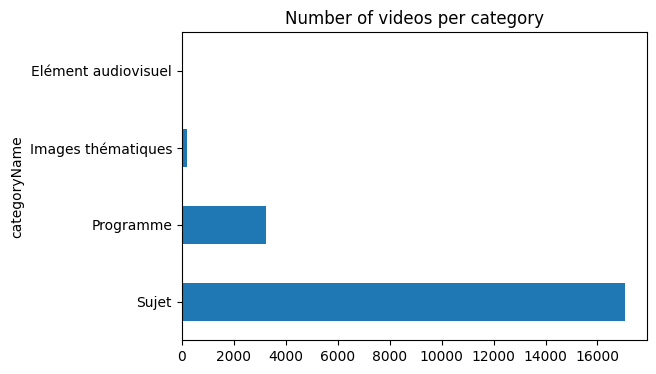

In [103]:
plt.figure(figsize=(6, 4))
df.groupby("rts_id").categoryName.agg(set).map(lambda x: list(x)[0]).value_counts().plot(kind="barh")
plt.title("Number of videos per category")
plt.show()

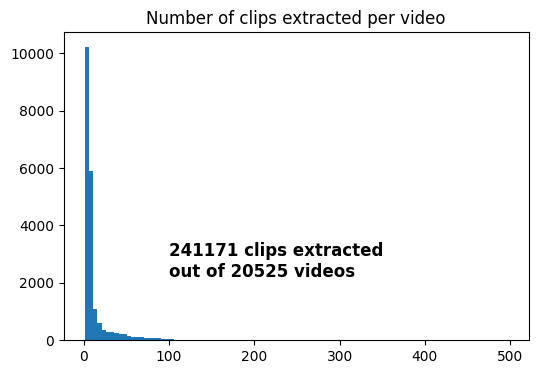

In [104]:
plt.figure(figsize=(6, 4))
df.rts_id.value_counts().hist(bins=100, grid = False)
plt.title("Number of clips extracted per video")
plt.text(100, 2200, f"{len(df)} clips extracted\nout of {len(df.rts_id.unique())} videos", fontdict={"size": 12, "weight": "bold"})
plt.show()

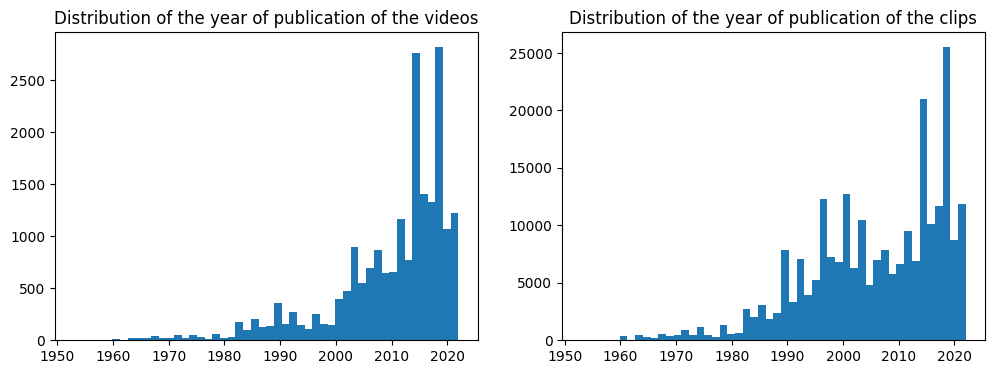

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df.groupby("rts_id").year.mean().hist(bins=50, ax=axs[0], grid = False)
axs[0].set_title("Distribution of the year of publication of the videos")
df.year.hist(bins=50, ax=axs[1], grid = False)
axs[1].set_title("Distribution of the year of publication of the clips")
plt.show()

## Extracting entities

In [111]:
def get_entities(data):
    entities = []
    if "entities" in data.keys():
        entities = data["entities"]
    else:
        entities = [t.get("entities", []) for t in data.get("transcript", [])]
        entities = [e for sublist in entities for e in sublist]
    
    return entities

In [112]:
df["entities"] = df["data"].apply(get_entities)

In [113]:
entity_types = list(set([e[1] for sublist in df.entities for e in sublist]))
entity_types

['ORG', 'PER', 'MISC', 'LOC']

In [114]:
df["locations"] = df["entities"].apply(lambda x: [e[0] for e in x if e[1] == "LOC" and len(e[0]) > 2])
df["people"] = df["entities"].apply(lambda x: [e[0] for e in x if e[1] == "PER" and len(e[0]) > 2])
df["orgs"] = df["entities"].apply(lambda x: [e[0] for e in x if e[1] == "ORG" and len(e[0]) > 1])
df["misc"] = df["entities"].apply(lambda x: [e[0] for e in x if e[1] == "MISC" and len(e[0]) > 2])

In [118]:
df = df[["media_id", "rts_id", "year", "categoryName", "contentType", "title", "resume", "mediaDuration", "locations", "people", "orgs", "misc"]]

In [119]:
df.to_csv("../data/rts_transcript_ner.csv", index=False, sep = "\t")

# Load presaved data

In [2]:
df = pd.read_csv("../data/rts_transcript_ner.csv", sep = "\t", converters={"locations": literal_eval,
                                                                           "people": literal_eval,
                                                                           "orgs": literal_eval,
                                                                           "misc": literal_eval})

In [3]:
df.head()

,media_id,rts_id,year,categoryName,contentType,title,resume,mediaDuration,locations,people,orgs,misc
0,rts-ZT001013,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",1675,"[Nyon, l'Europe, la France, Allemagne, Suisse,...","[Spielberg, Sarko Merkelenko, Zima, Nicolas Bu...","[Novartis, TTC, Novartis, Novartis, Novartis, ...","[Bonsoir, hiverdon, Vendredi matin, Record, ma..."
1,rts-ZT001013-M000,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",1675,[Nyon],[],"[Novartis, TTC]",[]
2,rts-ZT001013-M001,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",1675,[Nyon],[],[Novartis],[]
3,rts-ZT001013-M002,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",1675,[],[Yves Deferard],[UNIA],[]
4,rts-ZT001013-M003,ZT001013,2011,Programme,Autres émissions d'actualités,STUPEUR A NYON // DE LA SUEUR ET DES THUNES //...,"* Vaud : 20111031 et archives, les employés du...",1675,[],[],[],[]


# Locations

## Map of Switzerland

In [39]:
locations = df["locations"].explode().value_counts()
locations = pd.DataFrame(locations).reset_index().rename(columns={"locations":"location"})
locations[:10]

,location,count
0,Suisse,28857
1,Genève,9756
2,Est,7751
3,Lausanne,4612
4,Suisses,4001
5,État,3554
6,Europe,3420
7,Valais,3402
8,Allemagne,3345
9,Berne,3334


In [40]:
locations = df[["locations", "year"]].explode("locations").dropna().groupby("locations").agg(list).reset_index()
locations["count"] = locations["year"].apply(len)
locations["year"] = locations.year.map(lambda x: Counter(x))
locations = locations.sort_values("count", ascending=False)
locations.head(10)

,locations,year,count
30577,Suisse,"{2011: 425, 2010: 714, 2014: 1244, 2015: 798, ...",28857
12678,Genève,"{2010: 262, 2015: 395, 2016: 274, 2017: 276, 2...",9756
10587,Est,"{2011: 139, 2010: 172, 2015: 193, 2014: 252, 2...",7751
17761,Lausanne,"{2011: 109, 2015: 254, 2016: 276, 2019: 210, 2...",4612
30735,Suisses,"{2014: 188, 2015: 91, 2016: 81, 2018: 207, 201...",4001
42965,État,"{2015: 90, 2016: 128, 2017: 108, 2018: 114, 20...",3554
10842,Europe,"{2014: 111, 2015: 115, 2016: 138, 2018: 140, 2...",3420
33188,Valais,"{2010: 78, 2017: 133, 2018: 145, 2019: 170, 20...",3402
836,Allemagne,"{2011: 31, 2014: 170, 2016: 107, 2018: 159, 20...",3345
3545,Berne,"{2014: 74, 2016: 69, 2017: 105, 2019: 161, 200...",3334


In [41]:
with open("../emv/features/cities.json", "r") as f:
    cities = json.load(f)

In [42]:
cities = pd.DataFrame([{"locations":k, "lon":float(v[0]), "lat":float(v[1])} for k,v in cities.items() if len(v) == 2])

In [43]:
cities.head()

,locations,lon,lat
0,Bassecourt,47.350000,7.233333
1,Barberêche,46.850000,7.166667
2,Chésopelloz,46.800000,7.083333
3,Büren zum Hof,47.095556,7.513611
4,Cresciano,46.283333,9.000000


In [44]:
found_cities = pd.merge(locations, cities, on="locations", how="left").dropna(subset = ["lat", "lon"])
found_cities

,locations,year,count,lon,lat
1,Genève,"{2010: 262, 2015: 395, 2016: 274, 2017: 276, 2...",9756,46.200000,6.150000
3,Lausanne,"{2011: 109, 2015: 254, 2016: 276, 2019: 210, 2...",4612,46.533333,6.633333
9,Berne,"{2014: 74, 2016: 69, 2017: 105, 2019: 161, 200...",3334,46.947980,7.447430
13,Zurich,"{2015: 182, 2016: 171, 2018: 104, 2000: 90, 20...",2725,47.374444,8.541111
15,Neuchâtel,"{2010: 94, 2014: 81, 2016: 84, 2018: 142, 2019...",2594,46.990278,6.930556
...,...,...,...,...,...
42513,Muri,{2004: 1},1,47.274722,8.341667
42693,Magadino,{1993: 1},1,46.150000,8.850000
42864,Linn,{2014: 1},1,47.472222,8.130278
42872,Linden,{2002: 1},1,46.850000,7.683333


In [ ]:
# Create a base map centered around Switzerland
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8)
size_multiplier = 1
# Add city points to the map
for index, row in found_cities.iterrows():
    folium.CircleMarker(
        location=(row['lon'], row['lat']),
        radius=np.sqrt(row['count'] / np.pi) * size_multiplier,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        tooltip=row['locations'] + ': ' + str(row['count']) + ' occurrences'
    ).add_to(m)

m

## Evolution over time

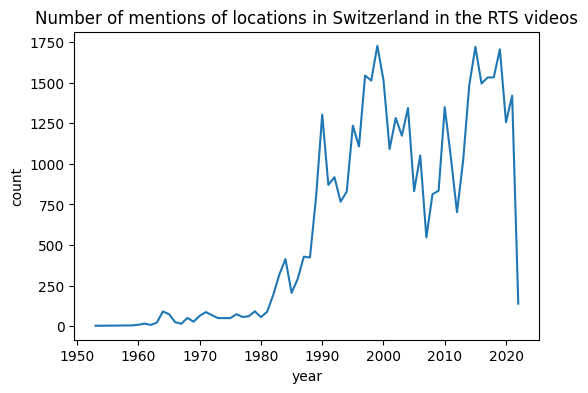

In [46]:
n_mentions_per_year = found_cities.year.sum()
n_mentions_per_year = pd.DataFrame(n_mentions_per_year.items(), columns=["year", "count"])
n_mentions_per_year = n_mentions_per_year.sort_values("year")

plt.figure(figsize=(6, 4))
sns.lineplot(data=n_mentions_per_year, x="year", y="count")
plt.title("Number of mentions of locations in Switzerland in the RTS videos")
plt.show()

In [47]:
n_mentions_per_year_dict = n_mentions_per_year.set_index("year").to_dict()["count"]
found_cities["relative_counts"] = found_cities.year.map(lambda x: {k:v / n_mentions_per_year_dict[k] for k,v in x.items()})

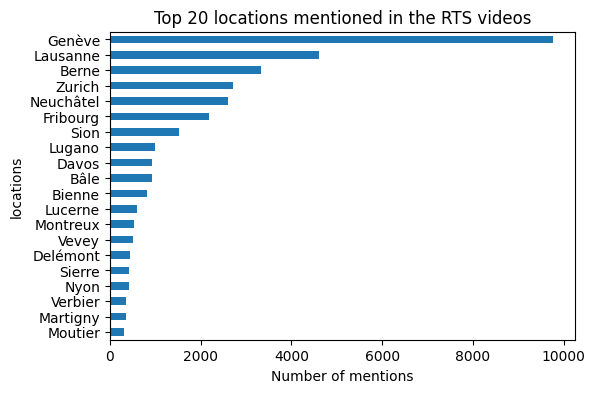

In [48]:
plt.figure(figsize=(6, 4))
found_cities[:20].sort_values("count").set_index("locations")["count"].plot(kind="barh")
plt.xlabel("Number of mentions")
plt.title("Top 20 locations mentioned in the RTS videos")
plt.show()

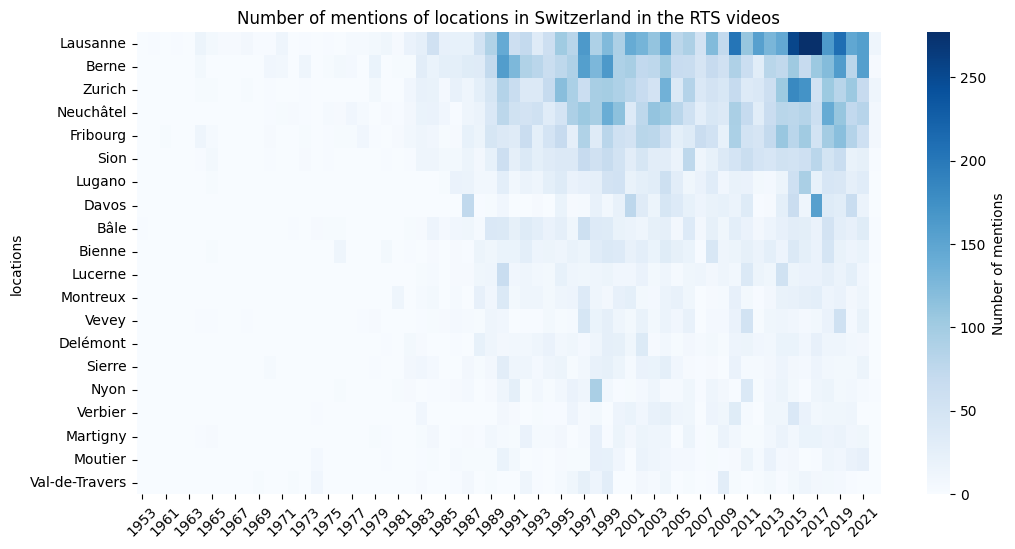

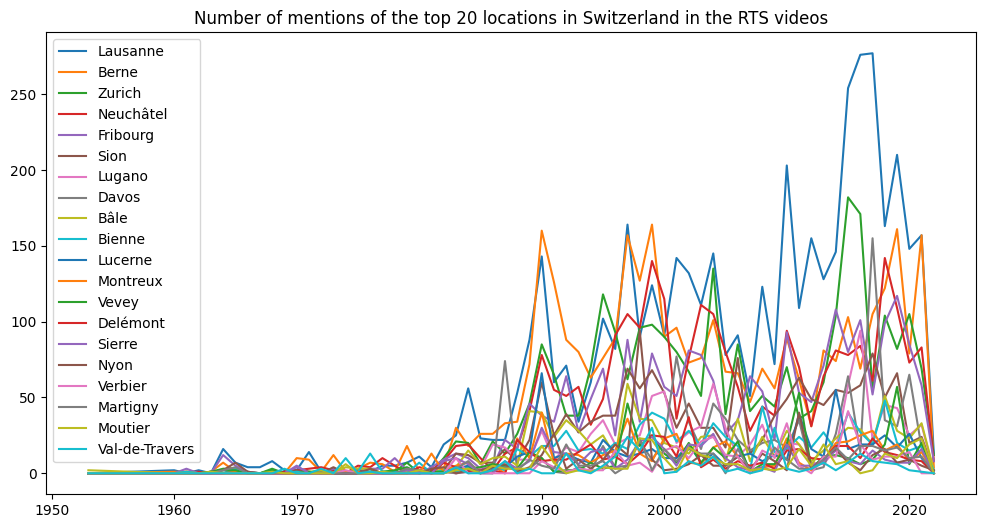

In [49]:
top_N = 20
skip_first_n = 1
top_cities = found_cities[skip_first_n:top_N + skip_first_n]
counts_per_year = pd.DataFrame(top_cities.year.tolist(), index=top_cities.locations).fillna(0)
counts_per_year = counts_per_year.T.sort_index().T

plt.figure(figsize=(12, 6))
sns.heatmap(counts_per_year, cmap="Blues", cbar_kws={'label': 'Number of mentions'})
plt.title("Number of mentions of locations in Switzerland in the RTS videos")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
for loc,mentions in counts_per_year.iterrows():
    plt.plot(mentions.index, mentions.values, label=loc)
plt.legend()
plt.title(f"Number of mentions of the top {len(counts_per_year)} locations in Switzerland in the RTS videos")
plt.show()

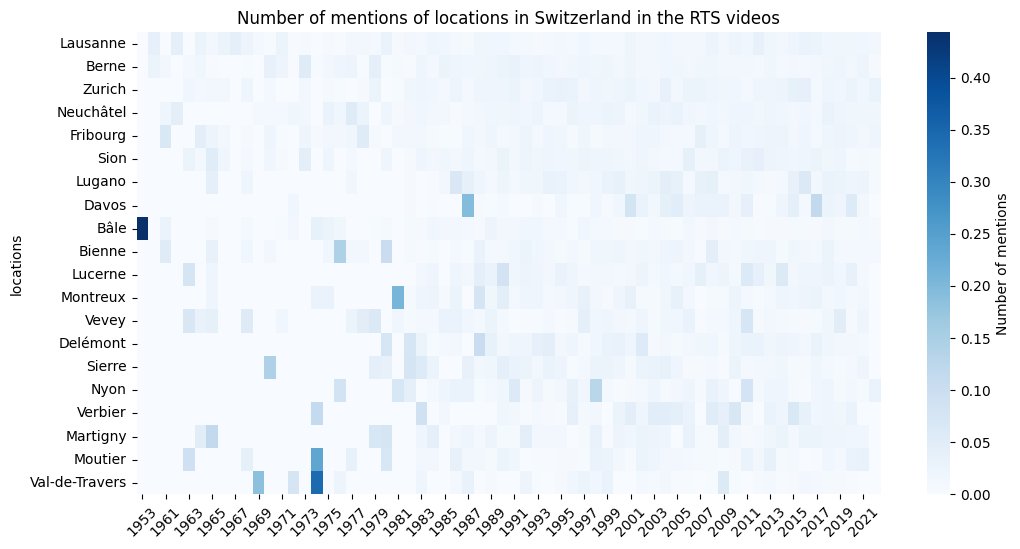

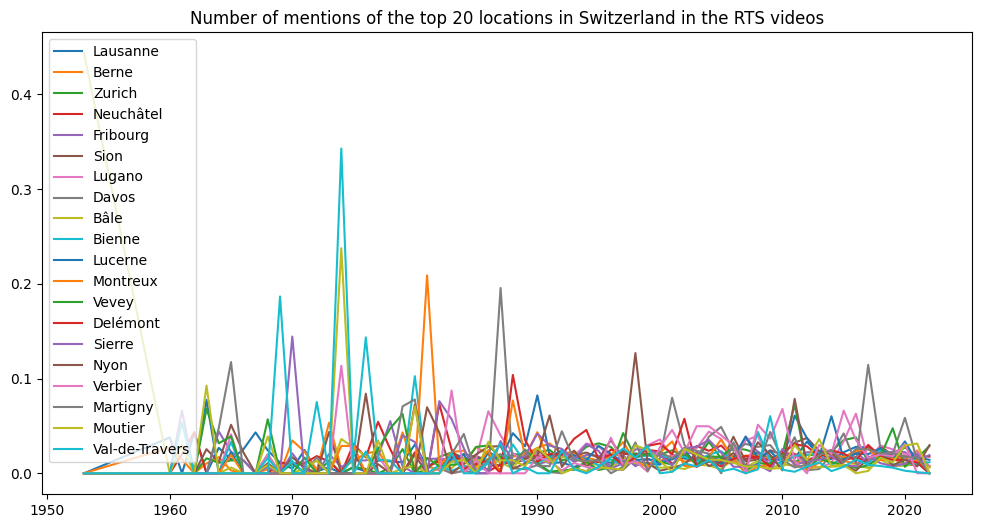

In [64]:
top_N = 20
skip_first_n = 1
top_cities = found_cities[skip_first_n:top_N + skip_first_n]
counts_per_year = pd.DataFrame(top_cities.relative_counts.tolist(), index=top_cities.locations).fillna(0)
counts_per_year = counts_per_year.T.sort_index().T

counts_per_year = counts_per_year.div(counts_per_year.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(counts_per_year, cmap="Blues", cbar_kws={'label': 'Number of mentions'})
plt.title("Number of mentions of locations in Switzerland in the RTS videos")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
for loc,mentions in counts_per_year.iterrows():
    plt.plot(mentions.index, mentions.values, label=loc)
plt.legend()
plt.title(f"Number of mentions of the top {len(counts_per_year)} locations in Switzerland in the RTS videos")
plt.show()

# People

In [4]:
filter_people = ["messieurs", "monsieur", "madame", "mesdames"]

df["people"] = df["people"].apply(lambda x: [p for p in x if p.lower() not in filter_people])   

In [5]:
persons = df[["people", "year"]].explode("people").dropna().groupby("people").agg(list).reset_index()
persons["count"] = persons["year"].apply(len)
persons["year"] = persons.year.map(lambda x: Counter(x))
persons = persons.sort_values("count", ascending=False)

In [6]:
top_persons = persons.head(1000)
top_persons.head(10)

,people,year,count
23201,Federer,"{2017: 49, 2000: 1, 2003: 71, 2004: 43, 2006: ...",1077
66442,Roger Federer,"{2017: 71, 2003: 75, 2004: 56, 2006: 212, 2008...",999
19624,Donald Trump,"{2019: 147, 2017: 136, 2016: 32, 2018: 168, 20...",706
61489,Philippe,"{2000: 16, 2006: 24, 2008: 34, 2002: 44, 2013:...",700
37989,Jésus,"{2012: 6, 2001: 30, 2002: 2, 2003: 12, 2000: 3...",641
82117,bidoum,"{2005: 45, 2002: 37, 2000: 296, 2007: 218}",596
15719,Covid,"{2021: 420, 2020: 144, 2022: 23, 1993: 1, 1990...",591
68054,Saddam Hussein,"{2001: 8, 2006: 26, 2002: 13, 1992: 12, 1993: ...",553
7705,Ben,"{2018: 19, 2005: 47, 1974: 3, 2012: 5, 1987: 4...",533
8895,Bill Clinton,"{2000: 36, 1993: 23, 1998: 112, 2014: 3, 2005:...",509


In [7]:
top_persons["wikidata_search"] = top_persons["people"].apply(get_wikidata_id)

/tmp/ipykernel_47020/1291365300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_persons["wikidata_search"] = top_persons["people"].apply(get_wikidata_id)


In [8]:
top_persons = top_persons[top_persons["wikidata_search"].map(lambda x: len(x) > 0)]

In [9]:
top_persons["wikidata_id"] = top_persons["wikidata_search"].apply(lambda x: x[0].get("id", "MISSING_ID") if len(x) > 0 else None)
top_persons["wikidata_label"] = top_persons["wikidata_search"].apply(lambda x: x[0].get("label", "MISSING_LABEL") if len(x) > 0 else None)
top_persons["wikidata_description"] = top_persons["wikidata_search"].apply(lambda x: x[0].get("description", "MISSING_DESCRIPTION") if len(x) > 0 else None)

In [10]:
instance_of = process_batch(top_persons["wikidata_id"].dropna().tolist(), "P31", BATCH_SIZE=20)
top_persons["instance_of"] = top_persons["wikidata_id"].map(instance_of)

In [11]:
instances = top_persons.instance_of.dropna().unique().tolist()
instances = {i:get_wikidata_label(i.split("/")[-1]) for i in instances}

In [12]:
top_persons["instance_of"] = top_persons["instance_of"].map(instances)
top_persons["instance_of"] = top_persons["instance_of"].fillna("MISSING").map(lambda x: x.get("en", {}).get("value", "MISSING") if x != "MISSING" else "MISSING")

In [32]:
top_persons["instance_of"].value_counts()

instance_of
human                            357
male given name                  126
family name                       98
female given name                 96
human biblical figure             20
                                ... 
district of Indonesia              1
Prayer in the Catholic Church      1
angels in Christianity             1
album                              1
symptom or sign                    1
Name: count, Length: 118, dtype: int64

## Focus on humans (instance of Q5)

In [33]:
top_persons.dropna(subset=["wikidata_id", "instance_of"], inplace=True)

In [34]:
top_persons = top_persons[top_persons.instance_of == "human"]

In [35]:
top_persons.shape

(357, 8)

In [36]:
ids = top_persons["wikidata_id"].tolist()
citizenship = process_batch(ids, "P27", BATCH_SIZE=20)
top_persons["citizenship"] = top_persons["wikidata_id"].map(citizenship)

occupation = process_batch(ids, "P106", BATCH_SIZE=20)
top_persons["occupation"] = top_persons["wikidata_id"].map(occupation)

In [42]:
citizenship_labels = {k:get_wikidata_label(k.split("/")[-1]) for k in top_persons["citizenship"].dropna().unique()}
top_persons["citizenship"] = top_persons["citizenship"].map(citizenship_labels)

occupation_labels = {k:get_wikidata_label(k.split("/")[-1]) for k in top_persons["occupation"].dropna().unique()}
top_persons["occupation"] = top_persons["occupation"].map(occupation_labels)

In [45]:
top_persons["citizenship"] = top_persons["citizenship"].fillna("MISSING").map(lambda x: x.get("en", {}).get("value", "MISSING") if x != "MISSING" else "MISSING")
top_persons["occupation"] = top_persons["occupation"].fillna("MISSING").map(lambda x: x.get("en", {}).get("value", "MISSING") if x != "MISSING" else "MISSING")

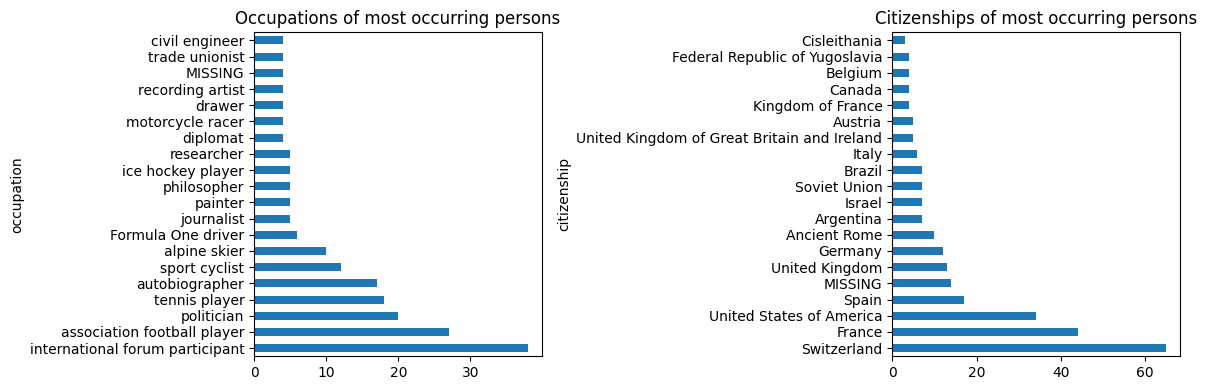

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
top_persons.occupation.value_counts()[:20].plot(kind="barh", ax=axs[0])
axs[0].set_title("Occupations of most occurring persons")
top_persons.citizenship.value_counts()[:20].plot(kind="barh", ax=axs[1])
axs[1].set_title("Citizenships of most occurring persons")
plt.tight_layout()
plt.show()